 ## Propeller
* Run the scene workshop1.ttt in CoppeliaSim

In [1]:
import sim
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Check if python is connecting to Coppelia

In [2]:
sim.simxFinish(-1)  # Close opened connections
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

if clientID != -1:
    print('Connected')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res, objs = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)

    print('Simulation time in milliseconds: ', sim.simxGetLastCmdTime(clientID))
    
    # Get Object position
    name = 'propeller'
    err_code, cuboid = sim.simxGetObjectHandle(clientID, name, sim.simx_opmode_blocking)
    res, position = sim.simxGetObjectPosition(clientID, cuboid, -1, sim.simx_opmode_blocking)        
    print(name, 'is at [x,y,z]=', position)
    
    
    returnCode = sim.simxSetFloatSignal(clientID,'f1', 100.0,sim.simx_opmode_oneshot_wait)
    #returnCode, signalValue=sim.simxGetFloatSignal(clientID,'particleVelocity',sim.simx_opmode_oneshot_wait)
    #print(signalValue)
    
    # Now close the connection to CoppeliaSim:
    sim.simxGetPingTime(clientID)
    sim.simxFinish(clientID)
    print('Disconnected')
else:
    print('Failed connecting to remote API server')


Connected
Simulation time in milliseconds:  6750
propeller is at [x,y,z]= [0.2933752238750458, -0.901472270488739, 2.2880747318267822]
Disconnected


## ROBOT

In [107]:
class robot():
    
    def __init__(self, frame_name, motor_names=[], client_id=0):  
        # If there is an existing connection
        if client_id:
                self.client_id = client_id
        else:
            self.client_id = self.open_connection()
            
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame =  self._get_handler(frame_name)
            
        
    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID
        
    def close_connection(self):    
        sim.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, sim.simx_opmode_streaming)      
            
    def set_position(self, position, relative_object=-1):
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)        
        sim.simxSetObjectPosition(clientID, self.frame, relative_object, position, sim.simx_opmode_oneshot)
        
    def simtime(self):
        return sim.simxGetLastCmdTime(self.client_id)
    
    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_oneshot)        
        return array(position)
    
    def get_velocity(self, relative_object=-1):
        # Get velocity relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, velocity, omega = sim.simxGetObjectVelocity(self.client_id, self.frame, sim.simx_opmode_blocking)        
        return array(velocity), array(omega)
    
    
    
    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        return array(position)
    
    def get_object_relative_position(self, object_name):        
        # Get Object position in the robot frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)
    
    def get_orientation(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, euler = sim.simxGetObjectOrientation(self.client_id, self.frame, relative_object, sim.simx_opmode_oneshot)        
        return array(euler)
    
    def get_quaternion(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, quaternion = sim.simxGetObjectQuaternion(self.client_id,relative_object,self.frame, sim.simx_opmode_blocking)        
        return array(quaternion)

    def set_forces(self, f, signal='f'):
        # For many propellers
        for i, fi in enumerate(f):
            signali = signal + str(i+1)
            sim.simxSetFloatSignal(clientID, signali, fi, sim.simx_opmode_oneshot)


## Finding A Matrix

In [213]:

kf = 20
km = 0.5

cube = robot('Cuboid')
reset = np.array([0,0,0,0,0,0])
cube.set_forces(reset)

A_Matrix = zeros((6,6))
Robots = ['propeller1','propeller2','propeller3','propeller4','propeller5','propeller6']

for x in range(6):
    prop_name = Robots[x]
    print (prop_name)
    quat = R.from_quat(cube.get_quaternion(prop_name)) 
    rot = quat.as_matrix()
    #prop_rot = np.transpose(rot)
    # To do- transpose of rot
    # To do - pos from cubiod to propeller
    pos = np.array(cube.get_object_relative_position(prop_name))
    print('Pos: ',pos)
    e3 = np.array([0,0,1])
    f = np.dot(rot,e3)
    torque = np.cross(pos,f)
    A_Matrix[:,x] = np.concatenate([f,torque])
print(A_Matrix)
rank = np.linalg.matrix_rank(A_Matrix)
print("The rank of the matrix is: ",rank)

#close propeller connections
cube.close_connection()


Robot connected
quat:  [ 0.05547901  0.05547889 -0.70492661  0.70492733]
matrix:  [[ 1.02122009e-06  1.00000000e+00 -8.34523042e-08]
 [-9.87688343e-01  9.95592366e-07 -1.56434452e-01]
 [-1.56434452e-01  2.42178874e-07  9.87688343e-01]]
orient  [ 1.40487913e-05  8.99999926e+00 -8.99999408e+01]
propeller1
Pos:  [ 0.1        -0.1         0.10000001]
propeller2
Pos:  [-0.1        -0.1         0.10000001]
propeller3
Pos:  [-0.1         0.1         0.10000001]
propeller4
Pos:  [0.1        0.1        0.10000001]
propeller5
Pos:  [-0.18100005  0.         -0.05      ]
propeller6
Pos:  [ 1.82000026e-01  3.72529030e-09 -4.99999970e-02]
[[ 7.07106833e-01 -5.72061450e-01 -7.07106833e-01  7.07106833e-01
  -8.74227777e-08 -8.34523042e-08]
 [-5.00000004e-01 -5.87785144e-01  5.00000004e-01  5.00000004e-01
   1.50995805e-07 -1.56434452e-01]
 [ 4.99999922e-01  5.72061467e-01  4.99999922e-01  4.99999922e-01
   1.00000000e+00  9.87688343e-01]
 [ 1.19333490e-08  1.57237209e-03 -1.19333490e-08 -1.19333490e-0

In [287]:
r = robot('Cuboid')
d = robot('Desired')


m = 8 + (0.1)*6
g = 9.81
I = 0.00667

log = []
log1 = []
log2 = []
log3 = []

while True:
        p = r.get_position()
        rad1 = r.get_orientation()
        theta = rad1
        v, ω = r.get_velocity()
        # Desired state
        p_d = d.get_position()
        print(p_d)
        rad2 = d.get_orientation()
        theta_d = (rad2)
    
        #print(theta_d)
        v_d, ω_d = d.get_velocity()

        ep = p_d - p
        ev = v_d - v
        eω = ω_d - ω
        etheta = theta_d - theta
    
        kp, kd = 6, 4
        a = kp * ep + kd * ev
        kp, kd = 151, 115
        a1 = kp*etheta + kd*eω

        rx = np.array([[1,0,0],[0,math.cos(theta[0]),math.sin(-theta[0])],[0,math.sin(theta[0]),math.cos(theta[0])]])
        ry = np.array([[math.cos(theta[1]),0,math.sin(theta[1])],[0,1,0],[math.sin(-theta[1]),0,math.cos(theta[1])]])
        rz = np.array([[math.cos(theta[2]),math.sin(-theta[2]),0],[math.sin(theta[2]),math.cos(theta[2]),0],[0,0,1]])

        tait_bryan = rz*ry*rx
        inv = np.linalg.inv(tait_bryan) 
        f = m * a
        f[2] += m*g
        # 1- Change the force from world frame to body frame
        print('force: ',f)
        force = np.dot(inv,f)
        torque = a1*0.00667
        wrench = np.array([[force[0]],[force[1]],[force[2]],[torque[0]],[torque[1]],[torque[2]]])
        print('wrench: ',wrench)
        A_inv = np.linalg.pinv(A_Matrix)
        u = np.dot(A_inv,wrench)
        #test = np.array([80,80,80,80,0,0])
        r.set_forces(u)
        print(u)
        log.append(ep)
        log1.append(f)
        log2.append(etheta)
        log3.append(torque)
        time.sleep(0.01)

Robot connected
Robot connected
[0. 0. 0.]
force:  [-1.06800949e-02  2.57837772e-02  8.43660000e+01]
wrench:  [[-1.06800949e-02]
 [ 2.57837772e-02]
 [ 8.43660000e+01]
 [ 3.23322690e-10]
 [ 1.47602805e-09]
 [ 4.84558815e-18]]
[[21.26067821]
 [42.13842046]
 [30.34213494]
 [43.15705295]
 [ 4.51373746]
 [ 8.47086059]]
[-1.07499969  0.35000008  0.87499988]
force:  [-55.47535523  19.09181597 124.355998  ]
wrench:  [[-5.58276468e+01]
 [ 1.92130569e+01]
 [ 1.24355998e+02]
 [-7.00546246e-09]
 [ 3.55841134e-09]
 [ 1.13206894e-01]]
[[-3.24382251]
 [66.37156111]
 [69.69688199]
 [47.68422005]
 [16.14074997]
 [13.34227002]]
[-1.07499969  0.35000008  0.87499988]
force:  [-55.4640535   19.07934954 124.3389233 ]
wrench:  [[-5.58162733e+01]
 [ 1.92005113e+01]
 [ 1.24338923e+02]
 [-3.19367250e-03]
 [ 8.87307849e-04]
 [ 1.09796586e-01]]
[[-3.31145567]
 [65.82869923]
 [69.55596887]
 [47.18784023]
 [16.49119299]
 [13.64144904]]
[-1.07499969  0.35000008  0.87499988]
force:  [-38.95838931  11.25782748 111.901

[-1.07499969  0.35000008  0.87499988]
force:  [ 0.29892573 -0.73457725 84.20037793]
wrench:  [[ 2.98942529e-01]
 [-7.34622439e-01]
 [ 8.42052490e+01]
 [-7.46077681e-02]
 [-5.45179252e-02]
 [-2.49488372e-04]]
[[21.42230245]
 [29.04680795]
 [28.20549085]
 [30.70532176]
 [12.23379301]
 [15.37766972]]
[-1.07499969  0.35000008  0.87499988]
force:  [ 0.22560754 -0.44797083 84.294968  ]
wrench:  [[ 2.25612860e-01]
 [-4.47984497e-01]
 [ 8.42955610e+01]
 [ 1.07532918e-03]
 [-2.82509657e-02]
 [-4.19108085e-03]]
[[21.46408444]
 [42.59807864]
 [29.98188179]
 [43.29943348]
 [ 4.23210006]
 [ 8.42578453]]
[-1.07499969  0.35000008  0.87499988]
force:  [-7.68940926e-02  3.68180037e-02  8.43682882e+01]
wrench:  [[-7.68964056e-02]
 [ 3.68193170e-02]
 [ 8.43712696e+01]
 [ 7.53138760e-02]
 [ 2.12816800e-02]
 [-2.29927178e-03]]
[[21.38998423]
 [55.71029291]
 [31.93722585]
 [55.50906759]
 [-3.46756169]
 [ 1.57032235]]
[-1.07499969  0.35000008  0.87499988]
force:  [-0.34807382  0.23544279 84.41445505]
wrench:

[-1.07499969  0.35000008  0.87499988]
force:  [-0.47045808  0.262424   84.36425306]
wrench:  [[-4.70461245e-01]
 [ 2.62424505e-01]
 [ 8.43649800e+01]
 [-1.13615301e-02]
 [ 5.99804064e-03]
 [ 1.60800876e-03]]
[[20.92338031]
 [40.05920584]
 [30.34736561]
 [41.16723314]
 [ 5.84124821]
 [ 9.50544923]]
[-1.07499969  0.35000008  0.87499988]
force:  [-0.37551227  0.08950764 84.36329347]
wrench:  [[-3.75512898e-01]
 [ 8.95077709e-02]
 [ 8.43635516e+01]
 [-3.63222427e-02]
 [-1.47043225e-02]
 [ 1.24957951e-03]]
[[20.96365356]
 [35.67720106]
 [29.70587686]
 [37.07463257]
 [ 8.41163072]
 [11.81576595]]
[-1.07499969  0.35000008  0.87499988]
force:  [-2.89539003e-01  6.21091723e-02  8.43629336e+01]
wrench:  [[-2.89540118e-01]
 [ 6.21093940e-02]
 [ 8.43635422e+01]
 [-2.52106470e-02]
 [-2.31263188e-02]
 [-3.10135492e-04]]
[[21.03845902]
 [37.71421585]
 [29.90765579]
 [38.97116924]
 [ 7.15843318]
 [10.80464746]]
[-1.07499969  0.35000008  0.87499988]
force:  [-0.30136981  0.20758965 84.36345853]
wrench:

force:  [-0.37584238  0.33394297 84.36296848]
wrench:  [[-3.75844875e-01]
 [ 3.33943772e-01]
 [ 8.43637299e+01]
 [-1.13356440e-02]
 [-2.14273112e-03]
 [ 5.75917184e-04]]
[[20.95171506]
 [40.03666438]
 [30.37495782]
 [41.2820619 ]
 [ 5.77526006]
 [ 9.49760805]]
[-1.07499969  0.35000008  0.87499988]
force:  [-0.33535314  0.2783187  84.36272961]
wrench:  [[-3.35354820e-01]
 [ 2.78319843e-01]
 [ 8.43634987e+01]
 [-1.69167759e-02]
 [-9.51612416e-03]
 [ 1.93219115e-04]]
[[20.9743503 ]
 [39.07135736]
 [30.21768655]
 [40.37846731]
 [ 6.33326192]
 [10.01710095]]
[-1.07499969  0.35000008  0.87499988]
force:  [-0.30983796  0.28982657 84.36263119]
wrench:  [[-3.09840139e-01]
 [ 2.89829665e-01]
 [ 8.43641239e+01]
 [-8.82480408e-03]
 [-1.06965636e-02]
 [-3.71740663e-04]]
[[21.00333094]
 [40.52895109]
 [30.39127612]
 [41.73837736]
 [ 5.45122424]
 [ 9.27556099]]
[-1.07499969  0.35000008  0.87499988]
force:  [-0.32403288  0.35371908 84.36327092]
wrench:  [[-3.24036440e-01]
 [ 3.53724578e-01]
 [ 8.43655

[-1.07499969  0.35000008  0.87499988]
force:  [-0.34752226  0.37833105 84.36320428]
wrench:  [[-3.47525098e-01]
 [ 3.78333893e-01]
 [ 8.43645267e+01]
 [-3.39777769e-03]
 [-1.41286980e-03]
 [ 1.91455294e-04]]
[[20.97415307]
 [41.4419005 ]
 [30.56474123]
 [42.62631723]
 [ 4.91728348]
 [ 8.7652451 ]]
[-1.07499969  0.35000008  0.87499988]
force:  [-0.33841028  0.35162972 84.36320428]
wrench:  [[-3.38412548e-01]
 [ 3.51632021e-01]
 [ 8.43643205e+01]
 [-8.25769001e-03]
 [-4.12354120e-03]
 [ 1.81509338e-04]]
[[20.97415786]
 [40.58345762]
 [30.44447069]
 [41.82443422]
 [ 5.42599097]
 [ 9.21401292]]
[-1.07499969  0.35000008  0.87499988]
force:  [-0.32306509  0.33693656 84.36320428]
wrench:  [[-3.23067185e-01]
 [ 3.36939333e-01]
 [ 8.43644464e+01]
 [-8.67767233e-03]
 [-6.46434101e-03]
 [-1.88726963e-05]]
[[20.98494216]
 [40.51978727]
 [30.4244396 ]
 [41.76381007]
 [ 5.457084  ]
 [ 9.25490805]]
[-1.07499969  0.35000008  0.87499988]
force:  [-0.31766844  0.34913541 84.36320428]
wrench:  [[-3.17670

[-1.07499969  0.35000008  0.87499988]
force:  [-0.33343601  0.36901557 84.36260044]
wrench:  [[-3.33438521e-01]
 [ 3.69018712e-01]
 [ 8.43639524e+01]
 [-4.66940494e-03]
 [-3.20898967e-03]
 [ 8.04823168e-05]]
[[20.98083348]
 [41.21930578]
 [30.52978189]
 [42.42451603]
 [ 5.04270824]
 [ 8.88307463]]
[-1.07499969  0.35000008  0.87499988]
force:  [-0.32884722  0.35916443 84.36250202]
wrench:  [[-3.28849544e-01]
 [ 3.59167466e-01]
 [ 8.43638122e+01]
 [-6.12318358e-03]
 [-4.32626317e-03]
 [ 4.98111844e-05]]
[[20.9822731 ]
 [40.96407802]
 [30.49239746]
 [42.1856982 ]
 [ 5.19305448]
 [ 9.01763202]]
[-1.07499969  0.35000008  0.87499988]
force:  [-0.32371302  0.3566532  84.36305973]
wrench:  [[-3.23715340e-01]
 [ 3.56656547e-01]
 [ 8.43644565e+01]
 [-5.63899899e-03]
 [-4.94076551e-03]
 [-3.33394795e-05]]
[[20.98688863]
 [41.05430867]
 [30.50056262]
 [42.26950681]
 [ 5.13701189]
 [ 8.973868  ]]
[-1.07499969  0.35000008  0.87499988]
force:  [-0.3236105   0.36369222 84.36302282]
wrench:  [[-3.23612

[-1.07499969  0.35000008  0.87499988]
force:  [-0.32909737  0.36631674 84.36317968]
wrench:  [[-3.29099817e-01]
 [ 3.66320045e-01]
 [ 8.43645700e+01]
 [-4.70715696e-03]
 [-3.75569700e-03]
 [ 2.92520230e-05]]
[[20.98385762]
 [41.21509648]
 [30.52689065]
 [42.4213311 ]
 [ 5.04332844]
 [ 8.88705502]]
[-1.07499969  0.35000008  0.87499988]
force:  [-0.32699571  0.36314784 84.36297464]
wrench:  [[-3.26998102e-01]
 [ 3.63151167e-01]
 [ 8.43643649e+01]
 [-5.05154898e-03]
 [-4.17036485e-03]
 [ 7.84213759e-06]]
[[20.98489743]
 [41.15527402]
 [30.51731798]
 [42.36529351]
 [ 5.07802024]
 [ 8.91905949]]
[-1.07499969  0.35000008  0.87499988]
force:  [-0.32533078  0.36341593 84.36299104]
wrench:  [[-3.25333199e-01]
 [ 3.63419402e-01]
 [ 8.43644231e+01]
 [-4.66230946e-03]
 [-4.28515780e-03]
 [-2.17892356e-05]]
[[20.98665627]
 [41.22561429]
 [30.52548673]
 [42.43096442]
 [ 5.03522552]
 [ 8.88343565]]
[-1.07499969  0.35000008  0.87499988]
force:  [-0.32599511  0.36659713 84.36313354]
wrench:  [[-3.25997

force:  [-0.32841458  0.36737474 84.36313354]
wrench:  [[-3.28417065e-01]
 [ 3.67378181e-01]
 [ 8.43645609e+01]
 [-4.28912039e-03]
 [-3.76598000e-03]
 [ 9.94293006e-06]]
[[20.98497324]
 [41.29005847]
 [30.53631702]
 [42.49125292]
 [ 4.99810849]
 [ 8.84867858]]
[-1.07499969  0.35000008  0.87499988]
force:  [-0.32791224  0.36600866 84.36313354]
wrench:  [[-3.27914688e-01]
 [ 3.66012061e-01]
 [ 8.43645477e+01]
 [-4.54901843e-03]
 [-3.89164913e-03]
 [ 6.05938720e-06]]
[[20.98487856]
 [41.24410185]
 [30.52983096]
 [42.44839233]
 [ 5.02541203]
 [ 8.87266793]]
[-1.07499969  0.35000008  0.87499988]
force:  [-0.32704492  0.36509418 84.36313354]
wrench:  [[-3.27047355e-01]
 [ 3.65097603e-01]
 [ 8.43645525e+01]
 [-4.60695180e-03]
 [-4.02092292e-03]
 [-5.80229151e-06]]
[[20.98538599]
 [41.23437266]
 [30.52788022]
 [42.43928967]
 [ 5.03087166]
 [ 8.87811886]]
[-1.07499969  0.35000008  0.87499988]
force:  [-0.32669225  0.36554374 84.36313354]
wrench:  [[-3.26694700e-01]
 [ 3.65547209e-01]
 [ 8.43645

[-1.07499969  0.35000008  0.87499988]
force:  [-0.32778511  0.36667299 84.36313354]
wrench:  [[-3.27787586e-01]
 [ 3.66676442e-01]
 [ 8.43645643e+01]
 [-4.35675379e-03]
 [-3.89263500e-03]
 [ 2.36066814e-06]]
[[20.98533396]
 [41.27847825]
 [30.53439701]
 [42.48049382]
 [ 5.00465452]
 [ 8.85499755]]


KeyboardInterrupt: 

In [288]:
    r.close_connection()
    d.close_connection()

Connection closed
Connection closed


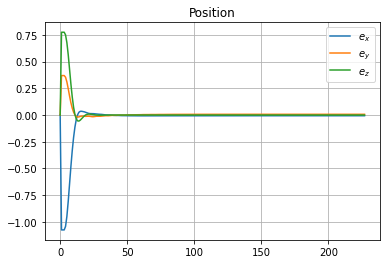

In [289]:
log = array(log)
plot(log[:,0], label='$e_x$')
plot(log[:,1], label='$e_y$')
plot(log[:,2], label='$e_z$')
title('Position')
legend()
grid()

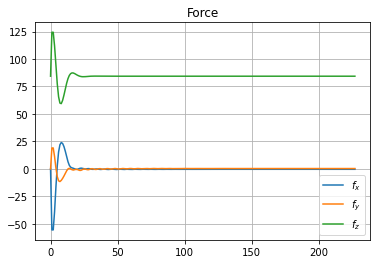

In [290]:
log1 = array(log1)
plot(log1[:,0], label='$f_x$')
plot(log1[:,1], label='$f_y$')
plot(log1[:,2], label='$f_z$')
legend()
title('Force')
grid()

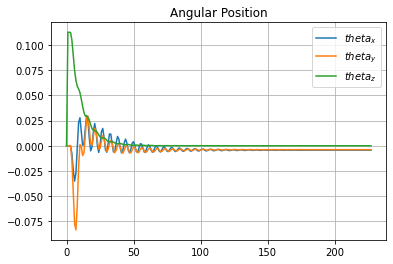

In [291]:
log2 = array(log2)
plot(log2[:,0], label='$theta_x$')
plot(log2[:,1], label='$theta_y$')
plot(log2[:,2], label='$theta_z$')
title('Angular Position')
legend()
grid()

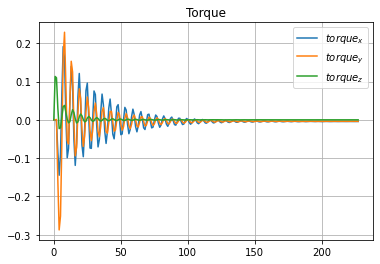

In [293]:
log3 = array(log3)
plot(log3[:,0], label='$torque_x$')
plot(log3[:,1], label='$torque_y$')
plot(log3[:,2], label='$torque_z$')
title('Torque')
legend()
grid()